<a href="https://colab.research.google.com/github/RobertoAlessandri/CNN_DOA/blob/main/Neural_Net_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Neural Networks 

This notebook is based on the paper *Deep learning assisted sound source localization using two orthogonal first-order differential microphone arrays* [Nian Liu, Huawei Chen, Kunkun Songgong, et al]. Features and networks' architectures are a direct implementation of the methods discussed in that paper, refer to it for a detailed explanation.

It is subdivided into 4 sections:

1.   **Imports and auxiliary functions** where we import libraries and define the core functions for feature extraction
2.   **Feature extraction and data exploration** where we plot and play some simulated examples together with the SI features
3.   **Training** where we show the learning curves
4.   **Testing** where we evaluated the models' performances



**PLEASE NOTE**: The actual training of the neural networks has been performed on a local machine with a GPU. In this Colab we uploaded the training output for easy consultation of the loss and accuracy curves.

## 1. Imports and auxiliary functions

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
from pathlib import Path
from tqdm import tqdm # Progress bar
from sklearn.utils import shuffle
import random
import sklearn
import re 
plt.style.use('seaborn')

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)

2.8.2


In [ ]:
# Mounting Google Drive to retrieve the datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Generate a matrix containing audio data as columns
# This function assumes the alphanumerical ordering of the filepaths
def extractAudiodata(filepaths, sample_len):
  sentencesNum = int(len(filepaths)/4) # Number of sentences
  sentencesId = np.zeros([sentencesNum, 1]) # Array containing all the sentences' ID
  labels30 = np.zeros(sentencesId.shape) # Lables for the model with resolution 30°
  labels10 = np.zeros(sentencesId.shape) # Lables for the model with resolution 10°

  # Ouput audio matrix N*M*L
  # N : Length of the audio files in number of samples
  # M : Number of microphones
  # L : Number of sentences
  audioSignals = np.zeros([int(sample_len), 4, sentencesNum]) 
  

  j = 0 # j is indexing sentences, range: [0, sentencesNum - 1]
  for i in tqdm(range(0, len(filepaths), 4)): # i is indexing samples, range: [0, len(filepath)] with step 4
    # Selecting the four microphones' input for a given sentence
    micsABCD = filepaths[i:i+4]
 
    for k in range(0, len(micsABCD)): # k is indexing mics, range: [0,3]
      # Populating the ouptut matrix
      # Loading k-th microphone's input of the j-th sentence as a column vector
      audioSignals[:, k, j] = librosa.load(micsABCD[k], sr=None)[0]

    # Extracting labels and sentence id from the sample relative to the first microphone
    fileid = micsABCD[0].split('.wav')[-2]
    sentencesId[j] = fileid.split('-')[-3]
    labels30[j] = fileid.split('-')[-2]
    labels10[j] = fileid.split('-')[-1]

    # Increasing sentence's index
    j += 1


  return audioSignals, sentencesId, labels30, labels10

In [ ]:
# This function sorts alphanumerically the list l
def sorted_nicely(l):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    
    return sorted(l, key = alphanum_key)

In [ ]:
# Sound Intensity (SI) estimation 
def computeSI(X1, X2, X3, freqsMatrix, isOblique=False, X4=0,  d=0.04, rho=1.225, beta=1e6):
  denominator = (freqsMatrix)*d*rho

  if isOblique:
    # Paricle velocity estimation in TF-domain relative to subarrays' directions (pi/4, 3/4pi, -pi/4, -3/4pi)
    X0 = (X1 + X2 + X3) / 3
    V1 = (np.sqrt(2)*1j*(X2 - X1)) / denominator
    V2 = (np.sqrt(2)*1j*(X2 - X3)) / denominator
  else:
    # Paricle velocity estimation in TF-domain relative to principal directions (x and y)
    X0 = (X1 + X2 + X3 + X4) / 4
    V1 = (1j*(X3 - X1)) / denominator
    V2 = (1j*(X4 - X2)) / denominator

  # Witheningh weight
  W = (np.abs(X0)**2 + beta*(np.abs(V1)**2 + np.abs(V2)**2) )**0.5 + np.finfo(np.float32).eps

  # Extracted SI features
  I1 = (np.real(X0*np.conj(V1)) / W).T
  I2 = (np.real(X0*np.conj(V2)) / W).T

  # Grouping features into a matrix
  matrix = np.zeros([I1.shape[0], I1.shape[1], 2])
  matrix[:, :, 0] = I1
  matrix[:, :, 1] = I2

  return matrix

In [ ]:
# Compute the SI features for each designated DMA (Differential Microphone Array): principal directions + subarrays
def featureExtractor2(micSignals, d=0.04, rho=1.225, NFFT=1024, sr=16000, beta=1e6):
  # STFT variables
  frame_length = NFFT
  hop_length = int(frame_length/2) # 50% overlap
  num_samples = micSignals[:,0].shape[0] # Length in samples
  num_frames = int(1 + np.floor((num_samples - frame_length) / hop_length)) # Resulting number of frames

  # freqMatrix is a matrix that contains the angular frequency axis repeated on each column
  # It is used for the SI estimation 
  freqs = librosa.fft_frequencies(sr=sr, n_fft=NFFT) / (sr/2) * np.pi + np.finfo(np.float32).eps
  freqs = np.reshape(freqs, (len(freqs),1))
  freqsMatrix = np.tile(freqs, (1, num_frames))

  # Init output matrix
  gamma = np.zeros([num_frames, int(NFFT/2 - 1), 10])

  # STFT microphones' signals
  P1 = librosa.stft(micSignals[:,0], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P2 = librosa.stft(micSignals[:,1], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P3 = librosa.stft(micSignals[:,2], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P4 = librosa.stft(micSignals[:,3], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)

  # Principal directions SI extraction 
  # First and last frequency bins are excluded because always equal to 0
  gamma[:,:,0:2] = computeSI(P1, P2, P3, freqsMatrix, isOblique=False, X4=P4, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2] 
  
  # Subarrays SI extraction
  gamma[:,:,2:4]  = computeSI(P4, P1, P2, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,4:6]  = computeSI(P1, P2, P3, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,6:8]  = computeSI(P2, P3, P4, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,8:10] = computeSI(P3, P4, P1, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]

  # Gamma is a 14*511*10 matrix where
  #   - 14 is the number of frames
  #   - 511 is the number of frequency bins
  #   - 10 is the number of channels (SI for each DMA) 

  return gamma

## 2. Feature extraction and data exploration

The wav files in each dataset are name encoded. 

**Name structure:** SA{ID}-{MIC}-{SENTENCE ID}-{CLASS30}-{CLASS10}.wav

The 'SENTENCE ID' identifies the unique sentence from the TIMIT dataset. But since we use 4 microphones in our simulation, each sentence is recorded 4 times. Thus the 'MIC' label identifies each individual microphone with the four letters A, B, C, or D to indicate the first, second, third, and fourth microphone respectively. The label 'ID' is used as a general unique identifier. Finally, 'CLASS30' and 'CLASS10' are the labels for the two neural networks, the first that classifies with a resolution of 30° and the second with the resolution of 10°.


E.g. SA17-B-0-8-23.wav: 
 * ID: 17 \
 * MIC: B (second mic) \
 * SENTENCE NUM: 0 \
 * CLASS30: 8 \
 * CLASS10: 23 \

In [ ]:
# Move into folder containing the test set
%cd /content/drive/MyDrive/Github/CNN_DOA/Dataset/MATLAB_TEST10

/content/drive/.shortcut-targets-by-id/1-B6wbQJimyIAQNh3Ccp578yl6uudDF9j/CNN_DOA/Dataset/MATLAB_TEST10


In [ ]:
# Get list of audio files in the current folder and sort them
audiofiles = [str(file) for file in Path().glob('SA*.wav')]
audiofiles = sorted_nicely(audiofiles)

In [ ]:
# Printing random files' names as example
random.choices(audiofiles, k=10)

['SA-830-C-207-20-20.wav',
 'SA-1418-C-354-35-35.wav',
 'SA-359-D-89-8-8.wav',
 'SA-1048-A-262-26-26.wav',
 'SA-219-D-54-5-5.wav',
 'SA-1296-A-324-32-32.wav',
 'SA-1387-D-346-34-34.wav',
 'SA-1409-B-352-35-35.wav',
 'SA-50-C-12-1-1.wav',
 'SA-856-A-214-21-21.wav']

In [ ]:
# Exctracting audio for the duration of 500 ms with respective labels
sr = 16000
duration = 0.5

audioMatrix, sourceIDs, labels30, labels10 = extractAudiodata(audiofiles, sr*duration) 

100%|██████████| 360/360 [00:29<00:00, 12.16it/s] 


In [ ]:
# Checking shapes
print('audioMatrix has shape {} where {} is length in samples, {} are the microphones and {} are the number of setences'.format(audioMatrix.shape, audioMatrix.shape[0], audioMatrix.shape[1], audioMatrix.shape[2]))

audioMatrix has shape (8000, 4, 360) where 8000 is length in samples, 4 are the microphones and 360 are the number of setences


In [ ]:
print('labels10 is an array of length {}, one for each sentence\n'.format(labels10.shape[0]))
print('All the possible classes are: {}'.format(np.unique(labels10)))

labels10 is an array of length 360, one for each sentence

All the possible classes are: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]


In [ ]:
# Listening to some examples: only from the first microphone
for i in range(0,10):
  ipd.display(ipd.Audio(audioMatrix[:,0,i], rate=sr))

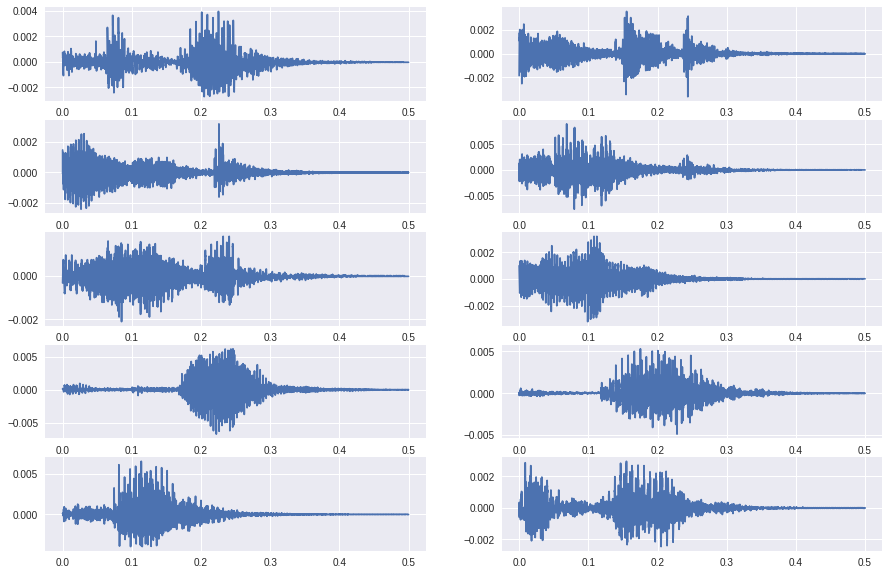

In [ ]:
# Visualizing some examples: only from the first microphone
plt.figure(figsize=(15, 10))
time_axis = np.arange(0,sr*duration) / sr
for i in range(0, 10):
  plt.subplot(5, 2, i+1)
  plt.plot(time_axis, audioMatrix[:,0,i])

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


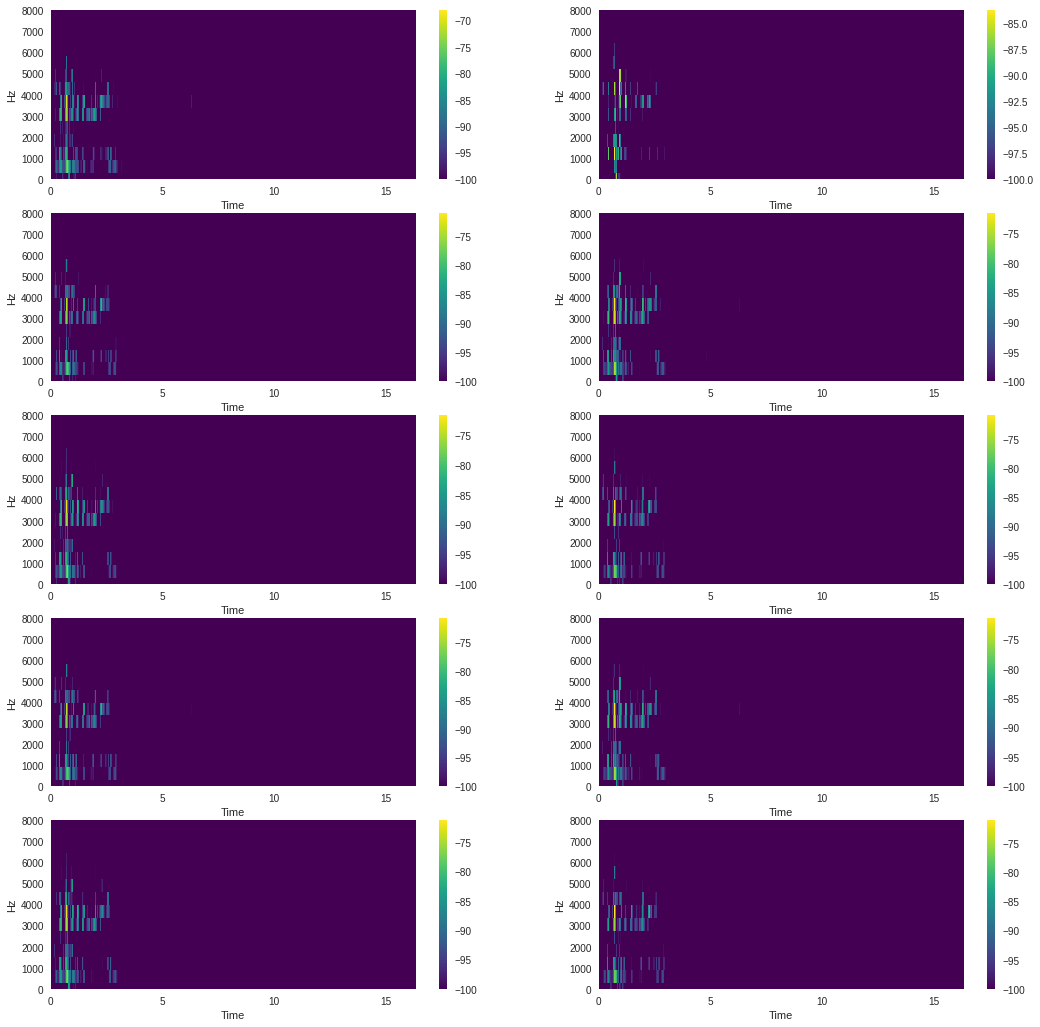

In [ ]:
# Visualizing SI estimated for the first sentence
gamma = featureExtractor2(audioMatrix[:,:,0])

plt.figure(figsize=(18, 18))
for i in range(0, 10):
  plt.subplot(5, 2, i+1)
  # Converion to db is perfomed only for better visualization
  librosa.display.specshow(librosa.amplitude_to_db(gamma[:,:,i]), sr=sr, x_axis='time', y_axis='linear', cmap='viridis')
  plt.colorbar();
  plt.clim(np.max(librosa.amplitude_to_db(gamma[:,:,i])), np.min(librosa.amplitude_to_db(gamma[:,:,i])))

In [ ]:
print(gamma.shape)

(14, 511, 10)


## 3. Training

**PLEASE NOTE:** this section ran on a local machine, we report it here just to show the code and the training curves (loss and accuracy).

Extracting features from the training dataset:

In [ ]:
# Get list of audio files in the train dataset
audiofiles_train = [str(file) for file in Path().glob('SA*.wav')]
audiofiles_train = sorted_nicely(audiofiles_train)

sr = 16000
duration = 0.5

# Extract audio and labels
trainAudioMatrix, sourceIDs, labels30, labels10 = extractAudiodata(audiofiles_train, sr*duration)

# Init gamma
datapointsNum = trainAudioMatrix.shape[-1]
Gamma_container = np.zeros([datapointsNum, 14, 511, 10])

# Extract SI features
for i in tqdm(range(0, datapointsNum)):
  Gamma_container[i,:,:,:] = featureExtractor2(trainAudioMatrix[:,:,i])

# Casting labels as integers
intLabels10 = np.array(labels10, dtype='uint8')
intLabels30 = np.array(labels30, dtype='uint8')

Extracting features from the validation dataset:

In [ ]:
# Get list of audio files in the validation dataset
audiofiles_val = [str(file) for file in Path().glob('SA*.wav')]
audiofiles_val = sorted_nicely(audiofiles_val)

sr = 16000
duration = 0.5

# Extract audio and labels
valAudioMatrix, sourceIDs, valLabels30, valLabels10 = extractAudiodata(audiofiles_val, sr*duration)

# Init gamma
datapointsNum = valAudioMatrix.shape[-1]
Gamma_container_val = np.zeros([datapointsNum, 14, 511, 10])

# Extract SI features
for i in tqdm(range(0, datapointsNum)):
  Gamma_container_val[i,:,:,:] = featureExtractor2(valAudioMatrix[:,:,i])

# Casting labels as integers
intValLabels10 = np.array(valLabels10, dtype='uint8')
intValLabels30 = np.array(valLabels30, dtype='uint8')

### 3.1 Model for resolution 10°

Network architecture with K = 36 output classes

In [ ]:
filters = 64
kernel_size = (3,3)
strides = (1,1)
input_shape = (14, 511, 10)
rate = 0.5
K = 36

model = keras.Sequential ([
  # input layer (14 * 511 * 10) (convolutional layers + batch normalization (BN) w ReLU)
  keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, input_shape=input_shape, activation='relu', name='conv1'),
  keras.layers.BatchNormalization(name = 'bn1'),

  # 2nd convolutional layers + batch normalization (BN) w ReLU
  keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', name='conv2'),
  keras.layers.BatchNormalization(name = 'bn2'),
  # dropout procedure with rate 0.5
  tf.keras.layers.Dropout(rate, name = 'dn1'),

  # 1st fully connected layer w ReLU & dropout procedure with rate 0.5
  keras.layers.Flatten(name='flatten'),
  tf.keras.layers.Dense(512, activation = 'relu', name = 'fc1'),
  tf.keras.layers.Dropout(rate, name = 'dn2'),

  # 2nd fully connected layer w ReLU & dropout procedure with rate 0.5
  tf.keras.layers.Dense(512, activation = 'relu', name = 'fc2'),
  tf.keras.layers.Dropout(rate, name = 'dn3'),

  # Output layer
  tf.keras.layers.Dense(K, activation = 'softmax', name = 'output'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 12, 509, 64)       5824      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 12, 509, 64)       256       
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 507, 64)       36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 10, 507, 64)       256       
_________________________________________________________________
dn1 (Dropout)                (None, 10, 507, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 324480)            0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               1

In [ ]:
# Compile
learning_rate = 1e-5 
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

In [ ]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


callbacks = [
  model_checkpoint_callback,
  tf.keras.callbacks.EarlyStopping(patience=25, monitor='accuracy', mode='max'),
]

In [ ]:
# Shuffling the features
(Gamma_container, intLabels10) = shuffle(Gamma_container, intLabels10)
(Gamma_container_val, intValLabels10) = shuffle(Gamma_container_val, intValLabels10)

In [ ]:
history = model.fit(Gamma_container, intLabels10, validation_data=(Gamma_container_val, intValLabels10),  epochs=400, callbacks=callbacks)

Epoch 1/400
188/188 [==============================] - 16s 75ms/step - loss: 3.5255 - accuracy: 0.0870 - val_loss: 3.5816 - val_accuracy: 0.0270
Epoch 2/400
188/188 [==============================] - 14s 75ms/step - loss: 3.1264 - accuracy: 0.1370 - val_loss: 3.5793 - val_accuracy: 0.0470
Epoch 3/400
188/188 [==============================] - 14s 77ms/step - loss: 2.7619 - accuracy: 0.1760 - val_loss: 3.4827 - val_accuracy: 0.0440
Epoch 4/400
188/188 [==============================] - 14s 77ms/step - loss: 2.5418 - accuracy: 0.2138 - val_loss: 7.0159 - val_accuracy: 0.0270
Epoch 5/400
188/188 [==============================] - 14s 76ms/step - loss: 2.4125 - accuracy: 0.2318 - val_loss: 5.5088 - val_accuracy: 0.0710
Epoch 6/400
188/188 [==============================] - 15s 76ms/step - loss: 2.3297 - accuracy: 0.2465 - val_loss: 3.9780 - val_accuracy: 0.0950
Epoch 7/400
188/188 [==============================] - 14s 77ms/step - loss: 2.2243 - accuracy: 0.2842 - val_loss: 5.5266 - val_ac

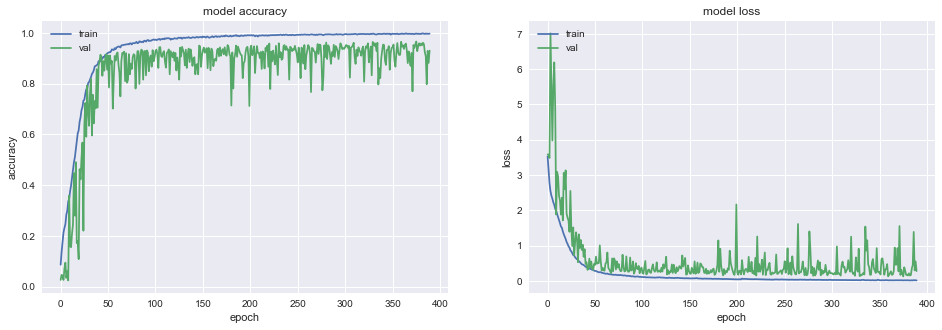

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

### 3.2 Model for resolution 30°

Network architecture with K = 12 output classes

In [ ]:
filters = 64
kernel_size = (3,3)
strides = (1,1)
input_shape = (14, 511, 10)
rate = 0.5
K = 12 

model = keras.Sequential ([
  # input layer (14 * 511 * 10) (convolutional layers + batch normalization (BN) w ReLU)
  keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, input_shape=input_shape, activation='relu', name='conv1'),
  keras.layers.BatchNormalization(name = 'bn1'),

  # 2nd convolutional layers + batch normalization (BN) w ReLU
  keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', name='conv2'),
  keras.layers.BatchNormalization(name = 'bn2'),
  # dropout procedure with rate 0.5
  tf.keras.layers.Dropout(rate, name = 'dn1'),

  # 1st fully connected layer w ReLU & dropout procedure with rate 0.5
  keras.layers.Flatten(name='flatten'),
  tf.keras.layers.Dense(512, activation = 'relu', name = 'fc1'),
  tf.keras.layers.Dropout(rate, name = 'dn2'),

  # 2nd fully connected layer w ReLU & dropout procedure with rate 0.5
  tf.keras.layers.Dense(512, activation = 'relu', name = 'fc2'),
  tf.keras.layers.Dropout(rate, name = 'dn3'),

  # SoftMax
  tf.keras.layers.Dense(K, activation = 'softmax', name = 'output'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 12, 509, 64)       5824      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 12, 509, 64)       256       
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 507, 64)       36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 10, 507, 64)       256       
_________________________________________________________________
dn1 (Dropout)                (None, 10, 507, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 324480)            0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               1

In [ ]:
# Compile
learning_rate = 1e-5 
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

In [ ]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model30',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


callbacks = [
  model_checkpoint_callback,
  tf.keras.callbacks.EarlyStopping(patience=100, monitor='accuracy', mode='max'),
]

In [ ]:
# Shuffling features
(Gamma_container, intLabels30) = shuffle(Gamma_container, intLabels30)
(Gamma_container_val, intValLabels30) = shuffle(Gamma_container_val, intValLabels30)

In [ ]:
history = model.fit(Gamma_container, intLabels30, validation_data=(Gamma_container_val, intValLabels30),  epochs=400, callbacks=callbacks)

Epoch 1/400
188/188 [==============================] - 25s 108ms/step - loss: 2.2880 - accuracy: 0.3123 - val_loss: 2.4830 - val_accuracy: 0.0840
Epoch 2/400
188/188 [==============================] - 17s 93ms/step - loss: 1.5516 - accuracy: 0.4523 - val_loss: 2.4764 - val_accuracy: 0.0945
Epoch 3/400
188/188 [==============================] - 17s 89ms/step - loss: 1.1743 - accuracy: 0.5515 - val_loss: 2.6756 - val_accuracy: 0.0842
Epoch 4/400
188/188 [==============================] - 17s 90ms/step - loss: 1.0156 - accuracy: 0.6098 - val_loss: 4.7218 - val_accuracy: 0.1042
Epoch 5/400
188/188 [==============================] - 18s 92ms/step - loss: 0.9277 - accuracy: 0.6475 - val_loss: 4.1365 - val_accuracy: 0.1703
Epoch 6/400
188/188 [==============================] - 17s 91ms/step - loss: 0.8276 - accuracy: 0.6872 - val_loss: 10.0541 - val_accuracy: 0.1565
Epoch 7/400
188/188 [==============================] - 17s 90ms/step - loss: 0.7617 - accuracy: 0.7175 - val_loss: 4.5444 - val_

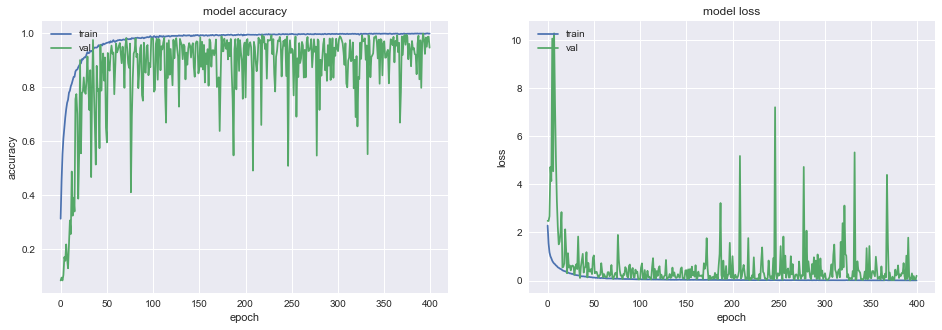

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

## 4. Testing

In this section, we test the models with two types of accuracy:
1.   The accuracy of the method *evaluate()* for which a prediction correct if and only if it is equal to the label
2.   The custom accuracy defined in the aforementioned paper where a prediction is considered correct also with an error of $\pm$ 1 class. E.g.: if the label indicates 10, I will also consider class 9 and 11 as a correct prediction.



### 4.1 Model for resolution 10°

In [ ]:
# Move into folder containing the test set for res 10°
%cd /content/drive/MyDrive/Github/CNN_DOA/Dataset/MATLAB_TEST10

/content/drive/.shortcut-targets-by-id/1-B6wbQJimyIAQNh3Ccp578yl6uudDF9j/CNN_DOA/Dataset/MATLAB_TEST10


In [ ]:
# Extract features
audiofiles_test = [str(file) for file in Path().glob('SA*.wav')]
audiofiles_test = sorted_nicely(audiofiles_test)

sr = 16000
duration = 0.5

testAudioMatrix, sourceIDs, testlabels30, testlabels10 = extractAudiodata(audiofiles_test, sr*duration)

datapointsNum = testAudioMatrix.shape[-1]
Gamma_container_test = np.zeros([datapointsNum, 14, 511, 10])


for i in tqdm(range(0, datapointsNum)):
  Gamma_container_test[i,:,:,:] = featureExtractor2(testAudioMatrix[:,:,i])

intTestLabels10 = np.array(testlabels10, dtype='uint8')

  0%|          | 0/360 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)
100%|██████████| 360/360 [00:03<00:00, 109.50it/s]


In [ ]:
%cd /content/drive/MyDrive/Github/CNN_DOA/models

/content/drive/.shortcut-targets-by-id/1-B6wbQJimyIAQNh3Ccp578yl6uudDF9j/CNN_DOA/models


In [ ]:
# Load the best model
model = keras.models.load_model('modelRes10')

# Compile
learning_rate = 1e-5 
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

In [ ]:
# Accuracy
model.evaluate(Gamma_container_test, intTestLabels10)

12/12 [==============================] - 7s 522ms/step - loss: 0.1941 - accuracy: 0.9500


[0.19411765038967133, 0.949999988079071]

In [ ]:
preds = model.predict(Gamma_container_test)

predsCategorical = np.zeros([preds.shape[0]])
for i in range(0, preds.shape[0]):
  predClass = np.argmax(preds[i])
  predsCategorical[i] = predClass

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]


In [ ]:
# Evaluating with custom accuracity (adjacent classes are considered true positives)
customAcc = 0

for i in range(0, predsCategorical.shape[0]):
    validRange = np.array([intTestLabels10[i,0]-1, intTestLabels10[i,0], intTestLabels10[i,0]+1])
    for j in range(validRange.shape[0]):
        if validRange[j] == -1:
            validRange[j] = 35
        if validRange[j] == 36:
            validRange[j] = 0
    print('{} in range {}'.format(predsCategorical[i], validRange))
    if predsCategorical[i] in validRange:
        #print('{} in range {}'.format(intTestLabels10[i], validRange))
        customAcc += 1

35.0 in range [35  0  1]
0.0 in range [35  0  1]
0.0 in range [35  0  1]
0.0 in range [35  0  1]
0.0 in range [35  0  1]
0.0 in range [35  0  1]
0.0 in range [35  0  1]
0.0 in range [35  0  1]
0.0 in range [35  0  1]
0.0 in range [35  0  1]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
4.0 in range [3 4 5]
4.0 in range [3 4 5]
4.0 in range [3 4 5]
4.0 in range [3 4 5]
4.0 in range [3 4 5]
4.0 in range [3 4 5]
4.0

In [ ]:
customAcc = customAcc / predsCategorical.shape[0] * 100
print('Custom accuracy of {}%'.format(customAcc))

Custom accuracy of 98.88888888888889%


### 4.2 Model for resolution 30°

In [ ]:
# Move into folder containing the test set for res 10°
%cd /content/drive/MyDrive/Github/CNN_DOA/Dataset/MATLAB_TEST30

/content/drive/.shortcut-targets-by-id/1-B6wbQJimyIAQNh3Ccp578yl6uudDF9j/CNN_DOA/Dataset/MATLAB_TEST30


In [ ]:
# Get list of audio files in the current folder
audiofiles_test = [str(file) for file in Path().glob('SA*.wav')]
audiofiles_test = sorted_nicely(audiofiles_test)

sr = 16000
duration = 0.5

testAudioMatrix, sourceIDs, testlabels30, testlabels10 = extractAudiodata(audiofiles_test, sr*duration)

datapointsNum = testAudioMatrix.shape[-1]
Gamma_container_test = np.zeros([datapointsNum, 14, 511, 10])

for i in tqdm(range(0, datapointsNum)):
  Gamma_container_test[i,:,:,:] = featureExtractor2(testAudioMatrix[:,:,i])

intTestLabels30 = np.array(testlabels30, dtype='uint8')

  0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)
100%|██████████| 120/120 [00:01<00:00, 102.18it/s]


In [ ]:
%cd /content/drive/MyDrive/Github/CNN_DOA/models

/content/drive/.shortcut-targets-by-id/1-B6wbQJimyIAQNh3Ccp578yl6uudDF9j/CNN_DOA/models


In [ ]:
model = keras.models.load_model('modelRes30')

# Compile
learning_rate = 1e-5 
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

In [ ]:
model.evaluate(Gamma_container_test, intTestLabels30)

4/4 [==============================] - 3s 538ms/step - loss: 0.0316 - accuracy: 0.9917


[0.031580325216054916, 0.9916666746139526]

In [ ]:
preds = model.predict(Gamma_container_test)

predsCategorical = np.zeros([preds.shape[0]])
for i in range(0, preds.shape[0]):
  predClass = np.argmax(preds[i])
  predsCategorical[i] = predClass

customAcc = 0

for i in range(0, predsCategorical.shape[0]):
    validRange = np.array([intTestLabels30[i,0]-1, intTestLabels30[i,0], intTestLabels30[i,0]+1])
    for j in range(validRange.shape[0]):
        if validRange[j] == -1:
            validRange[j] = 11
        if validRange[j] == 13:
            validRange[j] = 0
    print('{} in range {}'.format(predsCategorical[i], validRange))
    if predsCategorical[i] in validRange:
        #print('{} in range {}'.format(intTestLabels10[i], validRange))
        customAcc += 1

0.0 in range [11  0  1]
0.0 in range [11  0  1]
0.0 in range [11  0  1]
0.0 in range [11  0  1]
0.0 in range [11  0  1]
0.0 in range [11  0  1]
0.0 in range [11  0  1]
0.0 in range [11  0  1]
0.0 in range [11  0  1]
0.0 in range [11  0  1]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
1.0 in range [0 1 2]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
2.0 in range [1 2 3]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
3.0 in range [2 3 4]
4.0 in range [3 4 5]
4.0 in range [3 4 5]
4.0 in range [3 4 5]
4.0 in range [3 4 5]
4.0 in range [3 4 5]
4.0 in range [3 4 5]
4.0 

In [ ]:
customAcc = customAcc / predsCategorical.shape[0] * 100
print('Custom accuracy of {}%'.format(customAcc))

Custom accuracy of 100.0%
